XOR Train/Test: (600, 2) (300, 2)


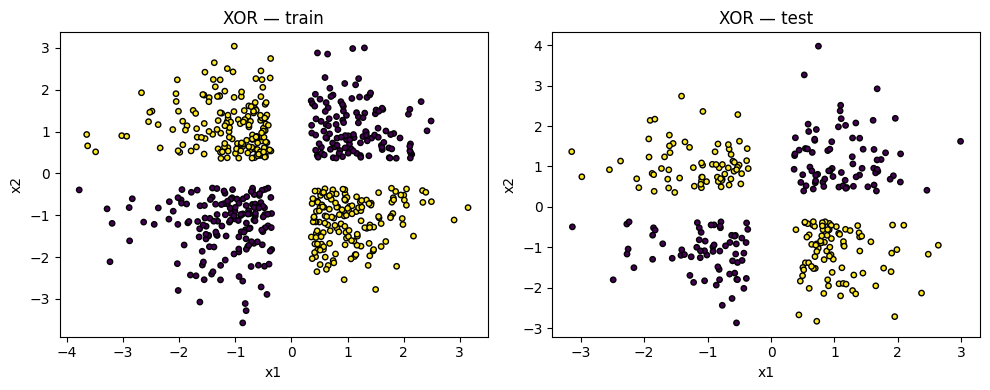

LogReg — Train acc: 0.6966666666666667  Test acc: 0.6366666666666667


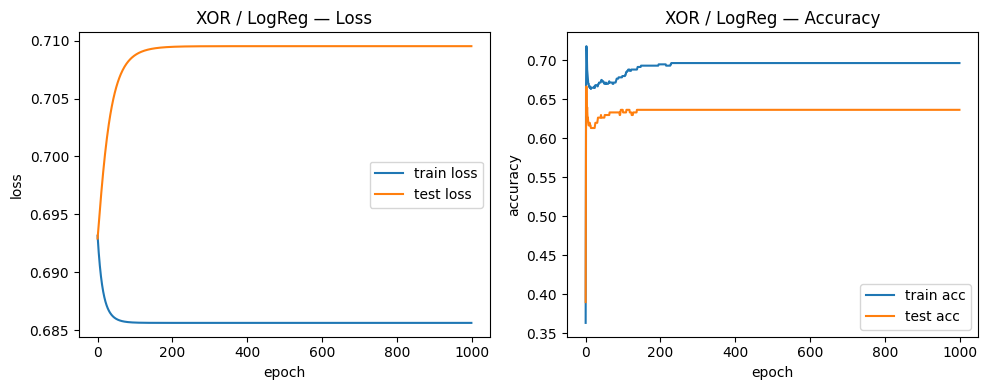

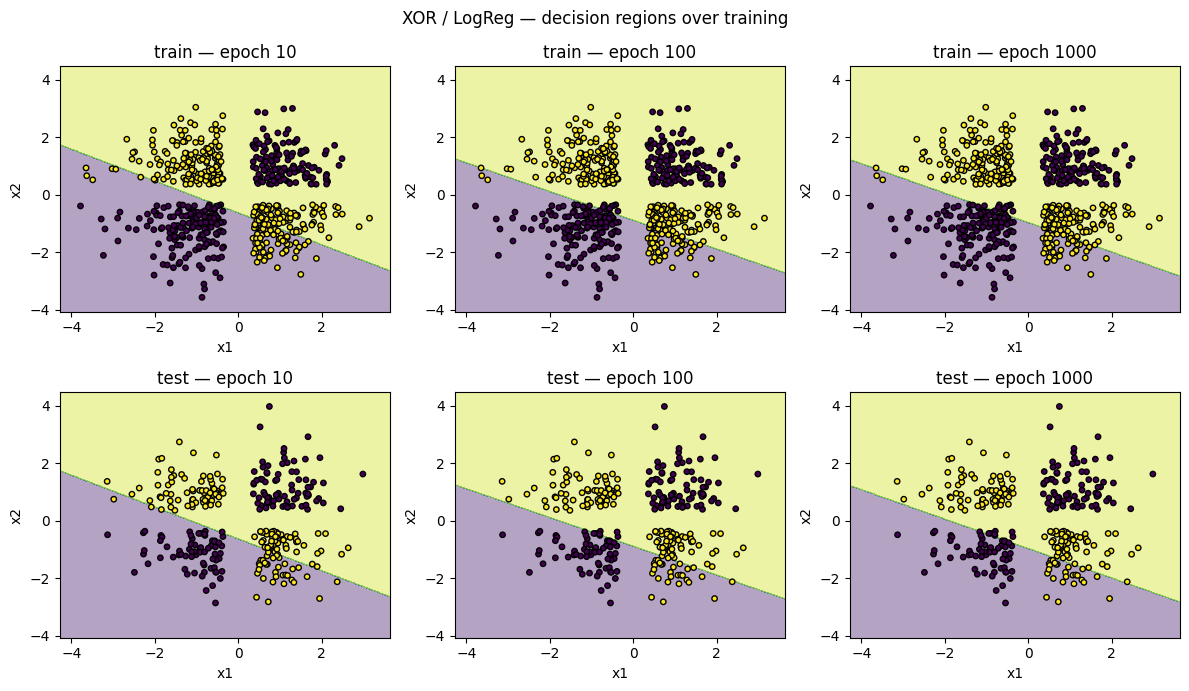

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

np.set_printoptions(precision=4, suppress=True)

GLOBAL_SEED = 42
rng = np.random.default_rng(GLOBAL_SEED)

# Separate seed just for XOR so the logistic baseline shows a visible line
SEED_XOR = 10

RUN_TRAINING = True


def relu(z):
    return np.maximum(0, z)
    

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(probs, y_true, eps=1e-12):
    p = np.clip(probs, eps, 1-eps)
    return -(y_true * np.log(p) + (1 - y_true) * np.log(1 - p)).mean()


def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean()


def make_meshgrid(X, X2=None, h=0.02, pad=0.5):
    if X2 is None:
        X2 = X
    Xcat = np.vstack([X, X2])
    x_min, x_max = Xcat[:,0].min() - pad, Xcat[:,0].max() + pad
    y_min, y_max = Xcat[:,1].min() - pad, Xcat[:,1].max() + pad
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    return xx, yy, grid

def plot_sets_side_by_side(X_train, y_train, X_test, y_test, title_prefix="Dataset — "):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=15, edgecolor="k")
    axes[0].set_title(f"{title_prefix}train"); axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")
    axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=15, edgecolor="k")
    axes[1].set_title(f"{title_prefix}test"); axes[1].set_xlabel("x1"); axes[1].set_ylabel("x2")
    plt.tight_layout(); plt.show()

def plot_curves_side_by_side(history, title_prefix=""):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].plot(history["loss"], label="train loss")
    if history.get("val_loss") is not None:
        axes[0].plot(history["val_loss"], label="test loss")
    axes[0].set_title(f"{title_prefix}Loss"); axes[0].set_xlabel("epoch"); axes[0].set_ylabel("loss"); axes[0].legend()
    axes[1].plot(history["acc"], label="train acc")
    if history.get("val_acc") is not None:
        axes[1].plot(history["val_acc"], label="test acc")
    axes[1].set_title(f"{title_prefix}Accuracy"); axes[1].set_xlabel("epoch"); axes[1].set_ylabel("accuracy"); axes[1].legend()
    plt.tight_layout(); plt.show()

def plot_decision_regions_side_by_side(X_train, y_train, X_test, y_test, model_proba_fn, title_prefix="Decision region — "):

    xx, yy, grid = make_meshgrid(X_train, X_test)
    with np.errstate(over='ignore', under='ignore'):
        Z = model_proba_fn(grid).reshape(xx.shape)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].contourf(xx, yy, (Z>=0.5).astype(int), alpha=0.4)
    axes[0].scatter(X_train[:,0], X_train[:,1], c=y_train, s=15, edgecolor="k")
    axes[0].set_title(f"{title_prefix}train"); axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")
    axes[1].contourf(xx, yy, (Z>=0.5).astype(int), alpha=0.4)
    axes[1].scatter(X_test[:,0], X_test[:,1], c=y_test, s=15, edgecolor="k")
    axes[1].set_title(f"{title_prefix}test"); axes[1].set_xlabel("x1"); axes[1].set_ylabel("x2")
    plt.tight_layout(); plt.show()

def _collect_metric_ranges(hist_a, hist_b, metric):

    series = []
    for H in (hist_a, hist_b):
        if metric in H and H[metric] is not None:
            series.append(np.array(H[metric], dtype=float))
        vm = f"val_{metric}"
        if vm in H and H[vm] is not None:
            series.append(np.array(H[vm], dtype=float))
    if not series:
        return None
    lo = min(s.min() for s in series)
    hi = max(s.max() for s in series)
    if lo == hi:
        lo -= 0.5
        hi += 0.5
    pad = 0.05 * (hi - lo)
    return (lo - pad, hi + pad)

def plot_compare_metric_pair(hist_a, hist_b, metric="loss",
                             left_title="Left", right_title="Right", match_ylim=True):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(hist_a.get(metric, []), label=f"train {metric}")
    vm = f"val_{metric}"
    if vm in hist_a and hist_a[vm] is not None:
        axes[0].plot(hist_a[vm], label=f"test {metric}")
    axes[0].set_title(left_title); axes[0].set_xlabel("epoch"); axes[0].set_ylabel(metric); axes[0].legend()
    axes[1].plot(hist_b.get(metric, []), label=f"train {metric}")
    if vm in hist_b and hist_b[vm] is not None:
        axes[1].plot(hist_b[vm], label=f"test {metric}")
    axes[1].set_title(right_title); axes[1].set_xlabel("epoch"); axes[1].set_ylabel(metric); axes[1].legend()
    if match_ylim:
        ylim = _collect_metric_ranges(hist_a, hist_b, metric)
        if ylim is not None:
            axes[0].set_ylim(*ylim)
            axes[1].set_ylim(*ylim)
    plt.tight_layout(); plt.show()


def snapshot_epoch_indices(epochs, positions=(0.1, 0.5, 1.0)):

    idx = sorted({max(1, min(epochs, int(round(p * epochs)))) for p in positions})
    return idx

def plot_snapshots_train_test(X_train, y_train, X_test, y_test, proba_fns, col_titles=("early","mid","late"), suptitle=None):

    xx, yy, grid = make_meshgrid(X_train, X_test)
    with np.errstate(over='ignore', under='ignore'):
        Zs = [fn(grid).reshape(xx.shape) for fn in proba_fns]
    ncols = len(proba_fns)
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 7))
    for j, Z in enumerate(Zs):
        ax = axes[0,j] if ncols>1 else axes[0]
        ax.contourf(xx, yy, (Z>=0.5).astype(int), alpha=0.4)
        ax.scatter(X_train[:,0], X_train[:,1], c=y_train, s=15, edgecolor="k")
        ax.set_title(f"train — {col_titles[j]}"); ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax = axes[1,j] if ncols>1 else axes[1]
        ax.contourf(xx, yy, (Z>=0.5).astype(int), alpha=0.4)
        ax.scatter(X_test[:,0], X_test[:,1], c=y_test, s=15, edgecolor="k")
        ax.set_title(f"test — {col_titles[j]}"); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    if suptitle: fig.suptitle(suptitle, y=0.98)
    plt.tight_layout(); plt.show()

def plot_snapshots_two_models(X, y, proba_fns_row1, proba_fns_row2, row_titles=("Model A","Model B"), col_titles=("early","mid","late"), suptitle=None):

    xx, yy, grid = make_meshgrid(X, X)
    with np.errstate(over='ignore', under='ignore'):
        Z1s = [fn(grid).reshape(xx.shape) for fn in proba_fns_row1]
        Z2s = [fn(grid).reshape(xx.shape) for fn in proba_fns_row2]
    ncols = len(proba_fns_row1)
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 7))
    for j in range(ncols):
        ax = axes[0,j] if ncols>1 else axes[0]
        ax.contourf(xx, yy, (Z1s[j]>=0.5).astype(int), alpha=0.4)
        ax.scatter(X[:,0], X[:,1], c=y, s=15, edgecolor="k")
        ax.set_title(f"{row_titles[0]} — {col_titles[j]}"); ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax = axes[1,j] if ncols>1 else axes[1]
        ax.contourf(xx, yy, (Z2s[j]>=0.5).astype(int), alpha=0.4)
        ax.scatter(X[:,0], X[:,1], c=y, s=15, edgecolor="k")
        ax.set_title(f"{row_titles[1]} — {col_titles[j]}"); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    if suptitle: fig.suptitle(suptitle, y=0.98)
    plt.tight_layout(); plt.show()


def plot_overlay_snapshots_two_models(X, y, proba_fns_a, proba_fns_b, labels=("Model A","Model B"),
                                      col_titles=("early","mid","late"), suptitle=None):

    xx, yy, grid = make_meshgrid(X, X)
    with np.errstate(over='ignore', under='ignore'):
        ZAs = [fn(grid).reshape(xx.shape) for fn in proba_fns_a]
        ZBs = [fn(grid).reshape(xx.shape) for fn in proba_fns_b]
    ncols = len(proba_fns_a)
    fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 4.8))
    if ncols == 1:
        axes = [axes]
    for j in range(ncols):
        ax = axes[j]
        ax.contour(xx, yy, ZAs[j], levels=[0.5], linewidths=2, linestyles='-')
        ax.contour(xx, yy, ZBs[j], levels=[0.5], linewidths=2, linestyles='--')
        ax.scatter(X[:,0], X[:,1], c=y, s=12, edgecolor="k")
        ax.set_title(col_titles[j], pad=10)  # add padding so titles don't touch legend
        ax.set_xlabel("x1"); ax.set_ylabel("x2")

    handles = [Line2D([0],[0], linestyle='-', linewidth=2, label=labels[0]),
               Line2D([0],[0], linestyle='--', linewidth=2, label=labels[1])]
    fig.legend(handles=handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    if suptitle: fig.suptitle(suptitle, y=1.10)
    # Reserve headroom for legend + suptitle
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

def _combine_minmax(*arrays):

    vals = [np.asarray(a, dtype=float) for a in arrays if a is not None and len(a)>0]
    if not vals:
        return None
    lo = min(v.min() for v in vals)
    hi = max(v.max() for v in vals)
    if lo == hi:
        lo -= 0.5
        hi += 0.5
    pad = 0.05 * (hi - lo)
    return (lo - pad, hi + pad)

def plot_grad_vel_traces(hist_a, hist_b, labels=("SGD","Momentum")):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(hist_a.get("grad_norm", []), label=f"{labels[0]} grad‖g‖")
    axes[0].plot(hist_b.get("grad_norm", []), label=f"{labels[1]} grad‖g‖")
    axes[0].set_title("Gradient norm vs. epoch"); axes[0].set_xlabel("epoch"); axes[0].set_ylabel("‖g‖₂"); axes[0].legend()
    axes[1].plot(hist_a.get("vel_norm", []), label=f"{labels[0]} velocity‖v‖")
    axes[1].plot(hist_b.get("vel_norm", []), label=f"{labels[1]} velocity‖v‖")
    axes[1].set_title("Parameter-velocity norm vs. epoch"); axes[1].set_xlabel("epoch"); axes[1].set_ylabel("‖v‖₂"); axes[1].legend()
    ylim0 = _combine_minmax(hist_a.get("grad_norm", []), hist_b.get("grad_norm", []))
    if ylim0: axes[0].set_ylim(*ylim0)
    ylim1 = _combine_minmax(hist_a.get("vel_norm", []), hist_b.get("vel_norm", []))
    if ylim1: axes[1].set_ylim(*ylim1)
    plt.tight_layout(); plt.show()


def generate_xor(n_samples=600, seed=0, spread=1.0, margin=0.35):


    rng_local = np.random.default_rng(seed)
    X = rng_local.normal(0, spread, size=(n_samples,2))
    signs = np.sign(X); signs[signs==0] = 1
    X = X + margin * signs
    y = (((X[:,0]>0) & (X[:,1]<0)) | ((X[:,0]<0) & (X[:,1]>0))).astype(int)
    return X, y

# Use SEED_XOR for XOR train/test
X_train, y_train = generate_xor(n_samples=600, seed=SEED_XOR)
X_test,  y_test  = generate_xor(n_samples=300, seed=SEED_XOR+1)
print("XOR Train/Test:", X_train.shape, X_test.shape)
plot_sets_side_by_side(X_train, y_train, X_test, y_test, title_prefix="XOR — ")


def init_logreg(d, rng = rng):

    W = rng.normal(0, 0.01, size=(d,))
    b = 0.0
    return W, b


def logreg_forward(W, b, X):

    Z = X @ W + b         # shape (N,)
    return sigmoid(Z)     # shape (N,)


def logreg_loss_and_grads(W, b, X, y):

    probs = logreg_forward(W, b, X)
    loss = binary_cross_entropy(probs, y)
    N = X.shape[0]
    dZ = (probs - y) / N   # dZ is the partial derivative of L with respect to Z, shape (N,)
    dW = X.T @ dZ    #shape (d,)
    db = dZ.sum()    #scalar

    return loss, dW, db   
    

def logreg_predict(W, b, X):

    probs = logreg_forward(W, b, X)
    y_pred = (probs >= 0.5)
    return y_pred, probs
    

def train_logreg_gd(
    X_train, y_train,
    X_val=None, y_val=None,
    *,
    epochs=1000,
    lr=0.1,
    reg=0.0,
    rng=None,
    snap_epochs=(10, 100, 1000),
    record_history=True,
):

    d = X_train.shape[1]
    W, b = init_logreg(d, rng=rng)

    history = {"loss": [], "acc": []}
    if X_val is not None and y_val is not None:
        history.update({"val_loss": [], "val_acc": []})

    snaps = []
    snap_set = set(snap_epochs or [])

    for ep in range(1, epochs + 1):

        # Replace the line below by computing loss, dW, db via the function logreg_loss_and_grads
        loss, dW, db = logreg_loss_and_grads(W, b, X_train, y_train)

        # (Optional) L2 regularization — keep consistent with your loss if used
        if reg:
            loss = loss + 0.5 * reg * (W @ W)
            dW = dW + reg * W

        # Replace the line below by updating W and b via gradient descent
        W -= lr * dW
        b -= lr * db

        if record_history:
            yhat_tr, p_tr = logreg_predict(W, b, X_train)
            history["loss"].append(binary_cross_entropy(p_tr, y_train))
            history["acc"].append(accuracy(y_train, yhat_tr))

            if X_val is not None and y_val is not None:
                yhat_val, p_val = logreg_predict(W, b, X_val)
                history["val_loss"].append(binary_cross_entropy(p_val, y_val))
                history["val_acc"].append(accuracy(y_val, yhat_val))

        if ep in snap_set:
            snaps.append((ep, W.copy(), float(b)))

    return (W, b), history, snaps

if RUN_TRAINING:
    (W, b), history, logreg_snaps = train_logreg_gd(
        X_train, y_train,
        X_val=X_test, y_val=y_test,
        epochs=1000, lr=0.1, reg=0.0, rng=rng,
        snap_epochs=(10, 100, 1000)
    )
    print("LogReg — Train acc:", history["acc"][-1], " Test acc:", history["val_acc"][-1])
    plot_curves_side_by_side(history, title_prefix="XOR / LogReg — ")
    # Snapshot decision regions (epochs 10,100,1000) for train & test
    proba_fns = [lambda Z, W_=W_, b_=b_: sigmoid(Z @ W_ + b_)
                  for (_, W_, b_) in logreg_snaps]
    plot_snapshots_train_test(X_train, y_train, X_test, y_test, proba_fns,
                              col_titles=[f"epoch {e}" for (e,_,_) in logreg_snaps],
                              suptitle="XOR / LogReg — decision regions over training")

In [ ]:
def init_mlp(d_in=2, d_hidden=8, rng=rng):

    return {"W1": rng.normal(0, 0.5, size=(d_in, d_hidden)),
            "b1": np.zeros(d_hidden),
            "W2": rng.normal(0, 0.5, size=(d_hidden, 1)),
            "b2": np.zeros(1)}


def mlp_forward(params, X):
    
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    Z1 = X @ W1 + b1        
    A1 = relu(Z1)           
    Z2 = A1 @ W2 + b2       
    probs = sigmoid(Z2).reshape(-1)
    cache = {"X": X, "Z1": Z1, "A1": A1, "Z2": Z2, "probs": probs}
    return probs, cache


def mlp_loss_and_grads(params, X, y):
    
    probs, cache = mlp_forward(params, X)
    loss = binary_cross_entropy(probs, y)
    N = X.shape[0]
    dZ2 = (probs - y).reshape(-1, 1) / N
    dW2 = cache['A1'].T @ dZ2
    db2 = dZ2.sum(axis=0)
    dA1 = dZ2 @ params['W2'].T
    dZ1 = dA1 * (cache['Z1'] > 0)
    dW1 = X.T @ dZ1
    db1 = dZ1.sum(axis=0)
    grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2 }
    return loss, grads 

    
def mlp_predict(params, X):
    
    probs, _ = mlp_forward(params, X) 
    y_pred = (probs >= 0.5)
    return y_pred, probs


def train_mlp_gd(
    X_train, y_train,
    X_val=None, y_val=None,
    *,
    d_hidden=8,
    epochs=1000,
    lr=0.1,
    reg=0.0,
    rng=None,
    snap_epochs=(10, 100, 1000),
    record_history=True,
):
    
    d_in = X_train.shape[1]
    params = init_mlp(d_in=d_in, d_hidden=d_hidden, rng=rng)

    history = {"loss": [], "acc": []}
    if X_val is not None and y_val is not None:
        history.update({"val_loss": [], "val_acc": []})  # will correct below

    snaps = []
    snap_set = set(snap_epochs or [])
    
    for ep in range(1, epochs + 1):
        # Backprop for the MLP
        loss, grads = mlp_loss_and_grads(params, X_train, y_train)
    
        # Optional L2 regularization on weights only (not biases)
        if reg:
            loss += 0.5 * reg * ((params['W1'] ** 2).sum() + (params['W2'] ** 2).sum())
            grads['W1'] = grads['W1'] + reg * params['W1']
            grads['W2'] = grads['W2'] + reg * params['W2']
    
        for k in params:
            params[k] -= lr * grads[k]
        
    
        if record_history:
            yhat_tr, p_tr = mlp_predict(params, X_train)
            history["loss"].append(binary_cross_entropy(p_tr, y_train))
            history["acc"].append(accuracy(y_train, yhat_tr))
    
            if X_val is not None and y_val is not None:
                yhat_val, p_val = mlp_predict(params, X_val)
                history["val_loss"].append(binary_cross_entropy(p_val, y_val))
                history["val_acc"].append(accuracy(y_val, yhat_val))
    
        if ep in snap_set:
            snaps.append((ep, {k: v.copy() for k, v in params.items()}))
    
    return params, history, snaps

if RUN_TRAINING:
    # Full-batch GD baseline for the 1-hidden-layer MLP (solution)
    params, history, mlp_snaps = train_mlp_gd(
        X_train, y_train,
        X_val=X_test, y_val=y_test,
        d_hidden=8, epochs=1000, lr=0.1, reg=0.0, rng=rng,
        snap_epochs=(10, 100, 1000)
    )
    print("MLP — Train acc:", history["acc"][-1], " Test acc:", history["val_acc"][-1])
    plot_curves_side_by_side(history, title_prefix="XOR / MLP — ")
    # Snapshot decision regions (epochs 10,100,1000) for train & test
    proba_fns = [lambda Z, P=P: mlp_forward(P, Z)[0] for (_, P) in mlp_snaps]
    plot_snapshots_train_test(X_train, y_train, X_test, y_test, proba_fns,
                              col_titles=[f"epoch {e}" for (e,_) in mlp_snaps],
                              suptitle="XOR / MLP — decision regions over training")

In [ ]:
def make_moons(n_samples=800, noise=0.18, seed=0):
    
    
    rng_local = np.random.default_rng(seed)
    N = n_samples
    t = rng_local.uniform(0, np.pi, size=(N//2,))
    x_inner = np.c_[np.cos(t), np.sin(t)]
    x_outer = np.c_[1 - np.cos(t), 1 - np.sin(t)] + np.array([0.0, -0.5])
    X = np.vstack([x_inner, x_outer])
    y = np.concatenate([np.zeros(N//2, dtype=int), np.ones(N//2, dtype=int)])
    X += rng_local.normal(0, noise, size=X.shape)
    return X, y

Xm_train, ym_train = make_moons(n_samples=800, noise=0.18, seed=GLOBAL_SEED)
Xm_test,  ym_test  = make_moons(n_samples=400, noise=0.18, seed=GLOBAL_SEED+1)
print("Moons Train/Test:", Xm_train.shape, Xm_test.shape)
plot_sets_side_by_side(Xm_train, ym_train, Xm_test, ym_test, title_prefix="Moons — ")

In [ ]:
def iterate_minibatches(X, y, batch_size=64, shuffle=True, rng=rng):
    
    N = X.shape[0]
    idx = np.arange(N)
    if shuffle:
        rng.shuffle(idx)
    for start in range(0, N, batch_size):
        end = min(start + batch_size, N)
        batch_idx = idx[start:end]
        yield X[batch_idx], y[batch_idx]

def step_decay(base_lr, epoch, decay_step_size, gamma, floor=0.0):
    
    k = epoch // decay_step_size
    return max(floor, base_lr * (gamma ** k))

In [ ]:
def sgd_train_mlp(X, y, Xval, yval, d_hidden=16, epochs=120, batch_size=64,
                  lr=0.2, decay_step_size=30, gamma=0.5, momentum=False, beta=0.9, rng=rng,
                  snapshot_positions=(0.05, 0.1, 1.0)):
    
    
    params = init_mlp(d_in=2, d_hidden=d_hidden, rng=rng)
    v = {k: np.zeros_like(vv) for k, vv in params.items()}
    history = {"loss": [], "acc": [], "val_loss": [], "val_acc": [], "grad_norm": [], "vel_norm": []}
    snap_epochs = snapshot_epoch_indices(epochs, positions=snapshot_positions)  # 6,12,120
    snapshots = []
    for epoch in range(1, epochs+1):
        lr_t = step_decay(lr, epoch-1, decay_step_size, gamma, floor=0.0)        
        
        # For each mini-batch, compute the SGD+momentum update in the heavy ball form if momentum=True, 
        # and the plain SGD update otherwise.
        for Xb, yb in iterate_minibatches(X, y, batch_size=batch_size, shuffle=True, rng=rng):
            loss, grads = mlp_loss_and_grads(params, Xb, yb)
            if momentum:
                for k in params:
                    v[k] = beta * v[k] - lr_t * grads[k]
                    params[k] += v[k]
            else:
                    for k in params:
                        params[k] -= lr_t * grads[k]
                            
        yhat_tr, p_tr = mlp_predict(params, X)
        yhat_te, p_te = mlp_predict(params, Xval)
        history["loss"].append(binary_cross_entropy(p_tr, y))
        history["acc"].append(accuracy(y, yhat_tr))
        history["val_loss"].append(binary_cross_entropy(p_te, yval))
        history["val_acc"].append(accuracy(yval, yhat_te))
        # full-data gradient & velocity norm traces
        _, gfull = mlp_loss_and_grads(params, X, y)
        gnorm = np.sqrt(sum((g**2).sum() for g in gfull.values()))
        vnorm = np.sqrt(sum((v[k]**2).sum() for k in v))
        history["grad_norm"].append(gnorm)
        history["vel_norm"].append(vnorm if momentum else 0.0)
        if epoch in snap_epochs:
            snapshots.append((epoch, {k:v.copy() for k,v in params.items()}))
    return params, history, snapshots

if RUN_TRAINING:
    params_sgd, hist_sgd, snaps_sgd = sgd_train_mlp(
        Xm_train, ym_train, Xm_test, ym_test,
        d_hidden=16, epochs=120, batch_size=64, lr=0.2,
        decay_step_size=30, gamma=0.5, momentum=False
    )
    params_mom, hist_mom, snaps_mom = sgd_train_mlp(
        Xm_train, ym_train, Xm_test, ym_test,
        d_hidden=16, epochs=120, batch_size=64, lr=0.2,
        decay_step_size=30, gamma=0.5, momentum=True, beta=0.9
    )
    print("SGD — Train acc:", hist_sgd["acc"][-1], " Test acc:", hist_sgd["val_acc"][-1])
    print("Momentum — Train acc:", hist_mom["acc"][-1], " Test acc:", hist_mom["val_acc"][-1])

    # === Metric comparison plots (matched y-limits) ===
    plot_compare_metric_pair(hist_sgd, hist_mom, metric="loss",
                             left_title="Moons - SGD: Loss", right_title="Moons - Momentum: Loss", match_ylim=True)
    plot_compare_metric_pair(hist_sgd, hist_mom, metric="acc",
                             left_title="Moons - SGD: Accuracy", right_title="Moons - Momentum: Accuracy", match_ylim=True)

    # === Snapshot region grids (epochs 6,12,120) — per-model ===
    proba_sgd = [lambda Z, P=P: mlp_forward(P, Z)[0] for (_, P) in snaps_sgd]
    proba_mom = [lambda Z, P=P: mlp_forward(P, Z)[0] for (_, P) in snaps_mom]
    col_titles = [f"epoch {e}" for (e, _) in snaps_sgd]

    plot_snapshots_two_models(Xm_train, ym_train, proba_sgd, proba_mom,
                              row_titles=("SGD (train)", "Momentum (train)"),
                              col_titles=col_titles,
                              suptitle="Moons — decision regions over training (TRAIN)")

    plot_snapshots_two_models(Xm_test, ym_test, proba_sgd, proba_mom,
                              row_titles=("SGD (test)", "Momentum (test)"),
                              col_titles=col_titles,
                              suptitle="Moons — decision regions over training (TEST)")

    # === Improved overlay panels at 6,12,120 — TRAIN & TEST ===
    plot_overlay_snapshots_two_models(Xm_train, ym_train, proba_sgd, proba_mom,
                                      labels=("SGD", "Momentum"),
                                      col_titles=col_titles,
                                      suptitle="Overlay decision boundary — TRAIN")
    plot_overlay_snapshots_two_models(Xm_test, ym_test, proba_sgd, proba_mom,
                                      labels=("SGD", "Momentum"),
                                      col_titles=col_titles,
                                      suptitle="Overlay decision boundary — TEST")

    # === Gradient/velocity traces ===
    plot_grad_vel_traces(hist_sgd, hist_mom, labels=("SGD","Momentum"))

In [ ]:
def multi_seed_eval(seeds=(42,43,44,45,46), d_hidden=16, epochs=80, batch_size=64,
                    lr=0.2, decay_step_size=30, gamma=0.5, beta=0.9):
    results = []
    for s in seeds:
        Xm_tr, ym_tr = make_moons(n_samples=800, noise=0.18, seed=s)
        Xm_te, ym_te = make_moons(n_samples=400, noise=0.18, seed=s+1)
        _, h_sgd, _ = sgd_train_mlp(Xm_tr, ym_tr, Xm_te, ym_te,
                                    d_hidden=d_hidden, epochs=epochs, batch_size=batch_size,
                                    lr=lr, decay_step_size=decay_step_size, gamma=gamma,
                                    momentum=False, rng=np.random.default_rng(s))
        _, h_mom, _ = sgd_train_mlp(Xm_tr, ym_tr, Xm_te, ym_te,
                                    d_hidden=d_hidden, epochs=epochs, batch_size=batch_size,
                                    lr=lr, decay_step_size=decay_step_size, gamma=gamma,
                                    momentum=True, beta=beta, rng=np.random.default_rng(s))
        results.append({
            "seed": s,
            "sgd_train_acc": h_sgd["acc"][-1],
            "sgd_test_acc":  h_sgd["val_acc"][-1],
            "mom_train_acc": h_mom["acc"][-1],
            "mom_test_acc":  h_mom["val_acc"][-1],
        })
    return results

if RUN_TRAINING:
    res = multi_seed_eval()
    sgd_tests = np.array([r["sgd_test_acc"] for r in res])
    mom_tests = np.array([r["mom_test_acc"] for r in res])
    print("SGD  test acc  mean±std:", sgd_tests.mean().round(4), "±", sgd_tests.std(ddof=1).round(4))
    print("Mom. test acc  mean±std:", mom_tests.mean().round(4), "±", mom_tests.std(ddof=1).round(4))
    plt.figure(figsize=(5,4))
    plt.boxplot([sgd_tests, mom_tests], labels=["SGD","Momentum"])
    plt.title("Test accuracy across seeds"); plt.ylabel("accuracy"); plt.show()
else:
    print("⏭️ Multi-seed experiment skipped until training is implemented.")

# --- Minimal CLI/Logging scaffold (safe if unused) -------------------------
import argparse, logging

def _setup_logging(verbosity: int = 1) -> None:
    level = logging.WARNING if verbosity <= 0 else (logging.INFO if verbosity == 1 else logging.DEBUG)
    logging.basicConfig(level=level, format="%(asctime)s | %(levelname)s | %(message)s")

def _parse_args(argv=None):
    p = argparse.ArgumentParser(description="Run Programming Activity 1")
    p.add_argument("--verbosity", "-v", action="count", default=0, help="Increase log verbosity (use -v, -vv)")
    return p.parse_args(argv)

def main(argv=None):
    args = _parse_args(argv)
    _setup_logging(args.verbosity)
    # The original notebook code executes on import below. Nothing else to do here.
    logging.info("Script ran successfully.")

if __name__ == "__main__":
    main()